In [293]:
import json
import os
import numpy as np
from tqdm import tqdm
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from operator import itemgetter
import pandas as pd
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.discrete.discrete_model import Poisson
import statsmodels.api as sm

In [294]:
wd = os.getcwd()
wd = wd.replace('.ipynb_checkpoints', '')
directory = os.path.join(wd, 'data', 'requests5')
retrieved_data =  []
names = []
for file in os.listdir(directory):
    with open(os.path.join(directory, file), "r") as j:
        a = json.loads(j.read())
        retrieved_data.append(a)
        print('Added ', file)
        names.append(file.split('.')[0].split('q')[1])
#retrieved_data
retrieved_data = sorted(retrieved_data, key=itemgetter('citationCount'), reverse=True)

Added  req4Seasons.json
Added  reqA2D2.json
Added  reqA3D.json
Added  reqA9.json
Added  reqaiMotive.json
Added  reqAmodalCityscapes.json
Added  reqAMUSE.json
Added  reqApolloScape.json
Added  reqArgoverse1Stereo.json
Added  reqArgoverse3DTracking.json
Added  reqArgoverseMotionForecasting.json
Added  reqAugKITTI.json
Added  reqAutomatumOpenHighway.json
Added  reqAutonomousPlatformInertial.json
Added  reqBayArea.json
Added  reqBDD100k.json
Added  reqBeyondPASCAL.json
Added  reqBLVD.json
Added  reqBoreas.json
Added  reqBoschSmallTrafficLightsDataset.json
Added  reqBoschTL.json
Added  reqBoxCars116k.json
Added  reqBoxy.json
Added  reqBrain4Cars.json
Added  reqCADC.json
Added  reqCADP.json
Added  reqCaltechLanes.json
Added  reqCaltechPedestrian.json
Added  reqCamVid.json
Added  reqCarlaScenes.json
Added  reqCARLAWildLifeCWL.json
Added  reqCARRADA.json
Added  reqCars.json
Added  reqCCSAD.json
Added  reqCityscapes3D.json
Added  reqCityscapesDVPS.json
Added  reqCODA.json
Added  reqComma2k19.js

In [295]:
print(len(names))
df_name = pd.DataFrame(names)
df_name.to_csv(f'output/retrieved_{len(names)}.csv', index=False, header=False, sep=",")

185


In [296]:
class scoring:
    def __init__(self, o_paper, lower_bound, upper_bound, impact_year):
        self.o_paper = o_paper
        self.lower_bound = o_paper['paperInfo']['year'] - lower_bound
        self.upper_bound = o_paper['paperInfo']['year'] + upper_bound
        self.impact_year = impact_year

    def number_citations_authors(self, author):
        """Returns a list where each entry is the number of citations a paper by a given author had up until the given year. Ignores citations without year resulting in different counts compared to the one given by the API."""
        ls_citations = []
        for paper in self.o_paper['paperInfo']['authors'][author]['authorsPapers']:
            #print(paper)
            if 'year' in paper and paper['year'] is not None and paper['year'] <= self.upper_bound:
                numb_cit = 0
                for citation in paper['citations']:
                    if 'year' in citation and citation['year'] is not None and self.upper_bound >= citation[
                        'year'] >= self.lower_bound:
                        numb_cit += 1
                else:
                    ls_citations.append(numb_cit)
        return ls_citations

    def number_citations_ref(self, dimension='references', dimension_papers='citations'):
        """Like number_citations but the list elements represent the citations the references of a paper received."""
        ls_citations = []
        for paper in self.o_paper['paperInfo'][dimension]:
            if paper['year'] is not None and paper['year'] <= self.upper_bound and 'citations' in paper.keys():
                numb_cit = 0
                for citation in paper[dimension_papers]: #TODO: maybe change dimension_paper and paper?
                    if citation['year'] is not None and self.upper_bound >= citation['year'] >= self.lower_bound:
                        numb_cit += 1
                else:
                    ls_citations.append(numb_cit)
        return ls_citations

    def just_citations(self):
        numb_cit = 0
        for paper in self.o_paper['paperInfo']['citations']:
            if paper['year'] is not None and self.o_paper['paperInfo']['year'] + self.impact_year >= paper[
                'year'] >= self.lower_bound:
                        numb_cit += 1
                        #print((paper['year'] + self.impact_year))
        return numb_cit
    def just_citations_non_cumulative(self):
        numb_cit = 0
        for paper in self.o_paper['paperInfo']['citations']:
            #print(paper)
            if paper['year'] is not None and self.o_paper['paperInfo']['year'] + self.impact_year == paper[
                'year']:
                        numb_cit += 1
                        #print((paper['year'] + self.impact_year))
        return numb_cit
    def reference_score(self):
        return calc_h_score(self.number_citations_ref())
    def citations_citations_score(self):
        return calc_h_score(self.number_citations_ref('citations', 'citations'))
    def citations_citations_sum(self):
        return np.sum(self.number_citations_ref('citations', 'citations'))
    def citations_single_author_score(self, author_number):
        return calc_h_score(self.number_citations_authors(author_number))


In [297]:
impact_year = 9
ind_paper = 0
print(retrieved_data[ind_paper]['id'])
scorer = scoring(retrieved_data[ind_paper], 200, 0, impact_year)
print(impact_year, retrieved_data[ind_paper]['paperInfo']['year']+impact_year, scorer.just_citations_non_cumulative())

KITTI
9 2022 987


In [298]:
retrieved_data[0]['paperInfo']['references'][0]

{'citations': [{'paperId': 'edb454208a16742615b0dd9c23a31d7bcde1dd3b',
   'year': 2022},
  {'paperId': '272fe83f6b9a80716952b20cb1d7cfd2f480a2c8', 'year': 2022},
  {'paperId': '0314cfdc5fac4f9a9b9195c73dea9e4a1203b471', 'year': 2021},
  {'paperId': 'ba426fe6e6af3d855cb5461725a7830dd8661ebf', 'year': 2022},
  {'paperId': '5df0f6b6372dfff270cac89bf7d0f461d69a2a4f', 'year': 2021},
  {'paperId': '51f349b27791484d41255944ad94e11690e2c710', 'year': 2020},
  {'paperId': '30863583187e6eb27efdbec50062bd53cf2f4fe6', 'year': 2020},
  {'paperId': '6990c3daf2da844ebdb2dea5877dedd45e5d5105', 'year': 2019},
  {'paperId': '3a7058616fdee4cb47de2f7c2ab9990660963d39', 'year': 2019},
  {'paperId': '9c5f7f314010ec8ba092e9d00444040dce021e96', 'year': 2019},
  {'paperId': '542de16b6f21c7089007a63a7504aec4a098a1f0', 'year': 2019},
  {'paperId': '37d446fe0421497544d67f9dc3c13abb3f16d2d4', 'year': 2018},
  {'paperId': '9b4001c8dbe3ed5b492ef1040d8fe622c523be97', 'year': 2018},
  {'paperId': '3887f78efaa5e751442f

In [299]:
retrieved_data[6]['paperInfo']['citations'][4]

{'paperId': '51324dc73ecfc8eb1f86013a81fab2ccf3ca3c57', 'year': 2022}

In [300]:
# 6 - camvid has some problem returns nones
for paper in retrieved_data:
    print(paper['id'], paper['citationCount'])

KITTI 5330
Cars 1939
nuImages 1805
nuScenes 1805
Synthia 1544
GTA5 1302
Caltech Pedestrian 1264
CamVid 993
Oxford Robot Car 950
Waymo Open Perception 888
GTSRB 758
Mapillary Vistas 754
Caltech Lanes 731
BDD100k 682
Beyond PASCAL 661
Argoverse 3D Tracking 593
Argoverse Motion Forecasting 593
GTSDB 588
LISA Traffic Sign 544
TT100K 441
CULane 430
TUD Brussels 416
ApolloScape 285
Road Damage 278
VPGNet 278
DDAD 265
NoCrash 218
Malaga Stereo and Laser Urban 211
INTERACTION 195
Brain4Cars 194
comma.ai 189
Oxford Radar Robot Car 173
Stanford Track Collection 171
India Driving 169
LISA Traffic Light 164
Bosch Small Traffic Lights Dataset 155
Bosch TL 155
DR(eye)VE 147
KITTI-360 141
JAAD 137
Nighttime Driving 137
TME Motorway 134
KAIST Multi-Spectral Day/Night 133
Lyft Level5 Perception 125
Lyft Level5 Prediction 125
One Thousand and One Hours 125
H3D 121
WoodScape 119
A2D2 117
Complex Urban 114
Synscapes 107
Waymo Open Motion 107
WildDash 104
UAH-DriveSet 97
BoxCars116k 96
Ground Truth Stixel 

In [301]:
retrieved_data[6]['publishDate']

'2010-03-01'

When do citations take off

In [302]:
# TODO: nuSecenes 60 citations stimmt nicht
def citation_timeline_array(retrieved_data):
    """Columns are years, rows datasets. column 0 is year prior to publication. column 1 year of pub. etc. entries are #citations that year"""
    array = np.zeros([len(retrieved_data), 16])
    names = []
    for paper_idx, paper in enumerate(tqdm(retrieved_data)):
        names.append(paper['id'])
        if 'paperInfo' in retrieved_data[paper_idx].keys() and 'year' in retrieved_data[paper_idx]['paperInfo'].keys():
            array_idx = 0
            for impact_year in range(-1, 2022-retrieved_data[paper_idx]['paperInfo']['year']+1, 1):
                # iterates from 1 year prior to publication until today. e.g. kitti pub in 2012 2011-2022 -> last entry column 9
                scorer = scoring(paper, 200, 0, impact_year)
                print(impact_year, scorer.just_citations())
                array[paper_idx][array_idx] = scorer.just_citations()
                array_idx += 1
    return array, names
array, name = citation_timeline_array(retrieved_data)
array

  0%|          | 0/185 [00:00<?, ?it/s]

-1 1
0 7
1 90
2 259
3 503
4 869
5 1454
6 2322
7 3355
8 4339
9 5326
-1 0
0 1
1 10
2 34
3 86
4 199
5 363
6 641
7 1035
8 1467
9 1946
-1 5
0 97
1 479
2 1056
3 1817
-1 5
0 97
1 479
2 1056
3 1817
-1 0
0 31
1 142
2 356
3 623
4 945
5 1269
6 1541
-1 0
0 23
1 125
2 304
3 521
4 773
5 1057
6 1301
-1 0
0 11
1 77
2 172
3 249
4 324
5 404
6 495
7 574
8 689
9 809
10 930
11 1059
12 1169
13 1263
-1 1
0 6
1 17
2 32
3 48
4 64
5 83
6 106
7 149
8 238
9 377
10 524
11 708
12 862
13 992
-1 8
0 56
1 169
2 330
3 558
4 760
5 949
-1 1
0 9
1 162
2 465
3 895
-1 1
0 14
1 34
2 50
3 77
4 111
5 148
6 217
7 325
8 443
9 571
10 667
11 759
-1 0
0 4
1 70
2 229
3 389
4 565
5 757
-1 0
0 1
1 5
2 17
3 36
4 64
5 105
6 151
7 208
8 275
9 356
10 455
11 532
12 629
13 684
14 733
-1 1
0 13
1 74
2 145
3 391
4 687
-1 0
0 11
1 58
2 111
3 182
4 303
5 410
6 508
7 598
8 659
-1 3
0 37
1 183
2 372
3 594
-1 3
0 37
1 183
2 372
3 594
-1 0
0 12
1 34
2 63
3 102
4 164
5 234
6 326
7 413
8 503
9 589
-1 0
0 5
1 23
2 58
3 121
4 165
5 233
6 295
7 380
8 45

100%|██████████| 185/185 [00:00<00:00, 1640.42it/s]

0 3
1 34
2 69
3 100
4 138
5 174
6 228
7 282
8 347
9 409
10 483
11 530
12 581
13 621
14 672
-1 0
0 2
-1 0
0 5
1 19
2 44
3 75
4 106
-1 0
0 6
1 20
2 36
3 58
4 74
5 89
6 123
7 151
8 184
9 229
10 263
11 294
-1 0
0 4
1 10
2 20
3 26
-1 0
0 1
1 1
-1 0
0 1
1 2
-1 0
0 4
1 14
2 22
3 29
-1 0
0 0
-1 0
0 7
1 48
2 83
3 118
4 157
-1 0
0 0
1 13
2 41
3 59
4 74
-1 0
0 4
1 42
2 154
3 269
4 403
-1 0
0 2
1 6
2 9
3 13
-1 0
0 0
1 5
2 20
-1 0
0 0
1 25
2 64
3 131
-1 0
0 0
1 3
-1 0
0 0
-1 0
0 1
-1 0
0 0
1 0
-1 2
0 4
1 14
-1 0
0 7
1 32
-1 0
0 2
1 30
-1 0
0 17
1 45
2 90
-1 0
0 13
1 46
2 85
3 150
4 210
-1 0
0 10
1 25
2 58
3 100
4 143
5 202
6 258
-1 0
0 5
-1 0
0 0
1 28
2 70
3 96
-1 0
0 0
1 0
-1 0
0 0
-1 0
0 3
-1 0
0 0
1 2
2 24
3 47
-1 0
0 0
-1 0
0 2
1 7
2 46
3 105
-1 0
0 2
1 29
2 58
-1 0
0 1
1 3
2 8
-1 0
0 0
1 7
-1 0
0 1
1 29
2 81
3 186
4 322
5 421
6 519
-1 0
0 0
-1 0
0 5
1 12
2 31
3 66
-1 0
0 0
1 5
2 9
3 14
4 16
-1 1
0 20
1 33
2 53
-1 0
0 1
1 5
2 8
-1 0
0 3
1 9
2 22
3 35
-1 0
0 0
1 1
-1 0
0 0


array([[  1.,   7.,  90., ...,   0.,   0.,   0.],
       [  0.,   1.,  10., ...,   0.,   0.,   0.],
       [  5.,  97., 479., ...,   0.,   0.,   0.],
       ...,
       [  0.,   3.,   9., ...,   0.,   0.,   0.],
       [  0.,   0.,   1., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

In [303]:
data = array
data = np.delete(data, np.s_[-12:], axis=1)
df = pd.DataFrame(data).set_axis(name)#
for column in range(df.shape[1]):
    if column >= 3:
        df = df[df[column] > 0]
data = np.array(df)

In [304]:
data

array([[1.000e+00, 7.000e+00, 9.000e+01, 2.590e+02],
       [0.000e+00, 1.000e+00, 1.000e+01, 3.400e+01],
       [5.000e+00, 9.700e+01, 4.790e+02, 1.056e+03],
       [5.000e+00, 9.700e+01, 4.790e+02, 1.056e+03],
       [0.000e+00, 3.100e+01, 1.420e+02, 3.560e+02],
       [0.000e+00, 2.300e+01, 1.250e+02, 3.040e+02],
       [0.000e+00, 1.100e+01, 7.700e+01, 1.720e+02],
       [1.000e+00, 6.000e+00, 1.700e+01, 3.200e+01],
       [8.000e+00, 5.600e+01, 1.690e+02, 3.300e+02],
       [1.000e+00, 9.000e+00, 1.620e+02, 4.650e+02],
       [1.000e+00, 1.400e+01, 3.400e+01, 5.000e+01],
       [0.000e+00, 4.000e+00, 7.000e+01, 2.290e+02],
       [0.000e+00, 1.000e+00, 5.000e+00, 1.700e+01],
       [1.000e+00, 1.300e+01, 7.400e+01, 1.450e+02],
       [0.000e+00, 1.100e+01, 5.800e+01, 1.110e+02],
       [3.000e+00, 3.700e+01, 1.830e+02, 3.720e+02],
       [3.000e+00, 3.700e+01, 1.830e+02, 3.720e+02],
       [0.000e+00, 1.200e+01, 3.400e+01, 6.300e+01],
       [0.000e+00, 5.000e+00, 2.300e+01, 5.800

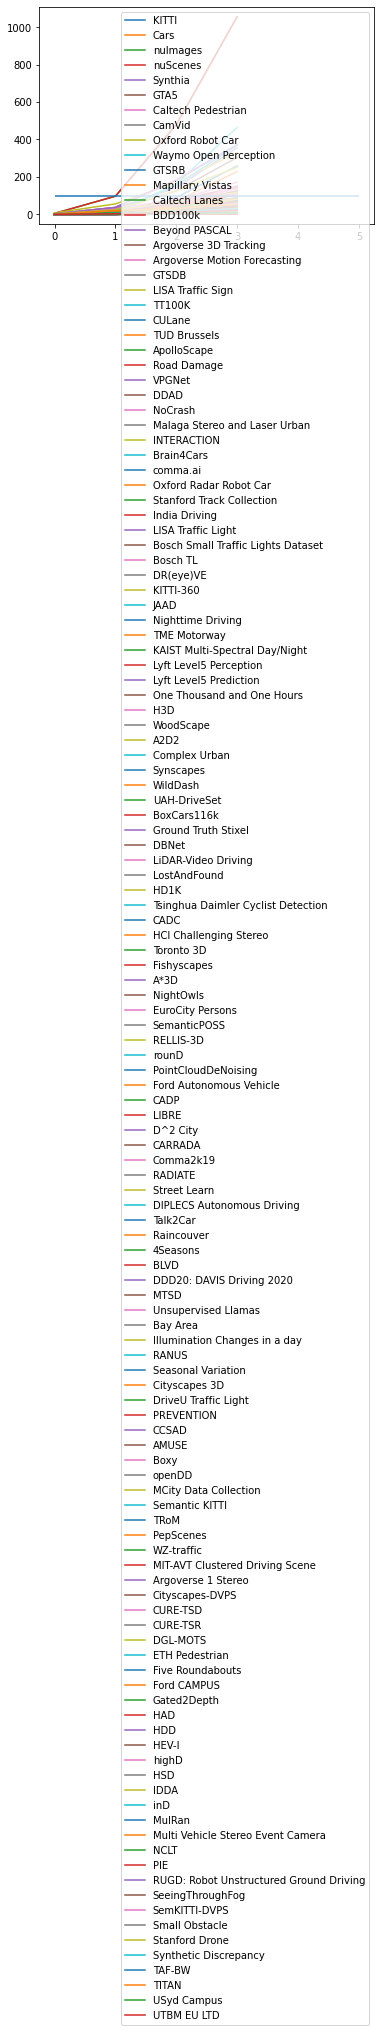

In [305]:
df_transpose = df.transpose()
df_transpose.plot()
plt.hlines(100, 0, 5)

In [306]:
df_transpose

,KITTI,Cars,nuImages,nuScenes,Synthia,GTA5,Caltech Pedestrian,CamVid,Oxford Robot Car,Waymo Open Perception,...,RUGD: Robot Unstructured Ground Driving,SeeingThroughFog,SemKITTI-DVPS,Small Obstacle,Stanford Drone,Synthetic Discrepancy,TAF-BW,TITAN,USyd Campus,UTBM EU LTD
0,1.0,0.0,5.0,5.0,0.0,0.0,0.0,1.0,8.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,7.0,1.0,97.0,97.0,31.0,23.0,11.0,6.0,56.0,9.0,...,0.0,2.0,2.0,1.0,1.0,5.0,0.0,20.0,1.0,3.0
2,90.0,10.0,479.0,479.0,142.0,125.0,77.0,17.0,169.0,162.0,...,2.0,7.0,29.0,3.0,29.0,12.0,5.0,33.0,5.0,9.0
3,259.0,34.0,1056.0,1056.0,356.0,304.0,172.0,32.0,330.0,465.0,...,24.0,46.0,58.0,8.0,81.0,31.0,9.0,53.0,8.0,22.0


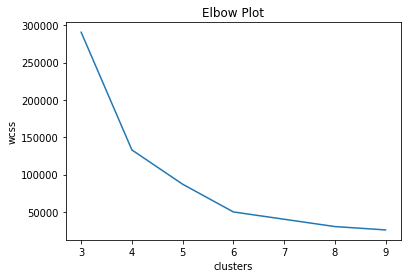

In [307]:
wcss = []
for k in range(3, 10):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(data)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)
plt.plot([*range(3, 10)], wcss)
plt.title('Elbow Plot')
plt.xlabel('clusters')
plt.ylabel('wcss')
plt.show()
#choose last bend

97
10
2
25


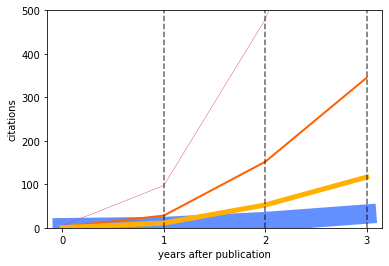

In [308]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(data)
clusters = kmeans.cluster_centers_
colors = ['#648fff', '#fe6100', '#dc267f', '#ffb000', '#785ef0', '#A740AE'] #
labels = pd.Series(kmeans.labels_)
labels = labels.value_counts(ascending=True).sort_index()
for label, cluster in enumerate(clusters):
    plt.plot([*range(0, cluster.shape[0])], cluster, alpha=1, label=label, color=colors[label] ,lw=labels.iloc[label]/5)
    print(labels.iloc[label])
y_lim = 500
plt.ylim(0, y_lim)
plt.vlines(1, 0, y_lim, colors='black', linestyles='dashed', alpha=0.6)
plt.vlines(2, 0, y_lim, colors='black', linestyles='dashed', alpha=0.6)
plt.vlines(3, 0, y_lim, colors='black', linestyles='dashed', alpha=0.6)
plt.xticks([*range(0, cluster.shape[0])])
plt.ylabel('citations')
plt.xlabel('years after publication')
#plt.title('Centers of Clusters from k-Means')
plt.savefig('output/citations_clustering.pdf', bbox_inches='tight')
#plt.legend()
#plt.hlines(50, 0, 5, linestyles='dashed', color='black')
plt.show()


In [309]:
#np.lexsort((kmeans.cluster_centers_[:,-1]))

In [310]:
labels = pd.Series(kmeans.labels_)
labels.value_counts(ascending=True)

2     2
1    10
3    25
0    97
dtype: int64

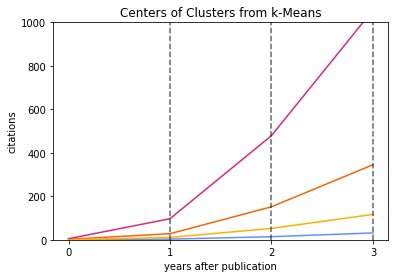

In [311]:
colors = ['#648fff', '#fe6100', '#dc267f', '#ffb000', '#785ef0', '#A740AE']
for idx, cluster in enumerate(clusters):
    plt.plot([*range(0, cluster.shape[0])], cluster, alpha=1, color=colors[idx])
y_lim = 1000
plt.ylim(0, y_lim)
plt.vlines(1, 0, y_lim, colors='black', linestyles='dashed', alpha=0.6)
plt.vlines(2, 0, y_lim, colors='black', linestyles='dashed', alpha=0.6)
plt.vlines(3, 0, y_lim, colors='black', linestyles='dashed', alpha=0.6)
plt.xticks([*range(0, cluster.shape[0])])
plt.ylabel('citations')
plt.xlabel('years after publication')
plt.title('Centers of Clusters from k-Means')
plt.savefig('output/citations_clustering_1000.svg')
#plt.hlines(50, 0, 5, linestyles='dashed', color='black')
plt.show()

In [312]:
def calc_h_score(citations):
    if citations:
        citations = np.array(citations)
        n         = citations.shape[0]
        array     = np.arange(1, n+1)
        # reverse sorting
        citations = np.sort(citations)[::-1]
        # intersection of citations and k
        h_idx = np.max(np.minimum(citations, array))
        return h_idx
    else:
        return 0

In [313]:
'''def expected_impact_score(o_paper, upper_bound, alpha=1, beta=1, gamma=1, theta=1): #Todo sum of weights = 1
    lower_bound = 5
    scorer = scoring(o_paper, lower_bound, upper_bound, 3)
    citation_c = scorer.just_citations(o_paper)
    reference_score_c = scorer.reference_score(o_paper)
    citations_citations_c = scorer.citations_citations_score(o_paper)
    ls_author_scores = []
    for author_number, author in enumerate(o_paper['paperInfo']['authors']):
        single_author_score = scorer.citations_single_author_score(o_paper, author_number)
        ls_author_scores.append(single_author_score)
    mean_author_score = np.mean(ls_author_scores)
    #print('Median author score', mean_author_score)
    return round(alpha*reference_score_c + beta*citations_citations_c + gamma*citation_c + theta*mean_author_score, 1)'''

"def expected_impact_score(o_paper, upper_bound, alpha=1, beta=1, gamma=1, theta=1): #Todo sum of weights = 1\n    lower_bound = 5\n    scorer = scoring(o_paper, lower_bound, upper_bound, 3)\n    citation_c = scorer.just_citations(o_paper)\n    reference_score_c = scorer.reference_score(o_paper)\n    citations_citations_c = scorer.citations_citations_score(o_paper)\n    ls_author_scores = []\n    for author_number, author in enumerate(o_paper['paperInfo']['authors']):\n        single_author_score = scorer.citations_single_author_score(o_paper, author_number)\n        ls_author_scores.append(single_author_score)\n    mean_author_score = np.mean(ls_author_scores)\n    #print('Median author score', mean_author_score)\n    return round(alpha*reference_score_c + beta*citations_citations_c + gamma*citation_c + theta*mean_author_score, 1)"

In [314]:
def create_modelling_df(retrieved_data, lower_bound, upper_bound, impact_year):
    array = np.zeros([len(retrieved_data), 5])

    for paper_idx, paper in enumerate(tqdm(retrieved_data)):
        if 'paperInfo' in retrieved_data[paper_idx].keys() and 'year' in retrieved_data[paper_idx]['paperInfo'].keys():
            array_idx = 0
            o_paper = retrieved_data[paper_idx]
            scorer = scoring(o_paper, lower_bound, upper_bound, impact_year)
            citation_c = scorer.just_citations()
            citations_citations_c = scorer.citations_citations_score()
            reference_score_c = scorer.reference_score()
            ls_author_scores = []
            for author_number, author in enumerate(o_paper['paperInfo']['authors']):
                single_author_score = scorer.citations_single_author_score(author_number)
                ls_author_scores.append(single_author_score)
            first_author_score = round(ls_author_scores[0], 0)
            if len(ls_author_scores)>1:
                #print(len(ls_author_scores), ls_author_scores)
                mean_author_score = round(np.mean(ls_author_scores[1:], 0))
            elif len(ls_author_scores)==2:
                mean_author_score = ls_author_scores[1]
            else:
                mean_author_score = 0
            array[paper_idx][:5] = [citation_c, citations_citations_c, reference_score_c,  mean_author_score, first_author_score]
            array_idx += 1
    names = []
    year = []
    sensors = []
    frames = []
    similar_age_3m = []
    row_w_missing_data = []
    missing_altmetirc_counter = 0
    for idx_paper, paper in enumerate(retrieved_data):
        names.append(paper['id'])
        year.append(paper['paperInfo']['year'])
        try:
            similar_age_3m_value = paper['altmetrics'][2]['similar_age_3m_percentile']['percentile']
        except:
            row_w_missing_data.append(idx_paper)
            missing_altmetirc_counter += 1
            print('Missing_Altmetric', missing_altmetirc_counter)
            continue
        try:
            sensors_value = int(len(list(paper['sensors'].split(','))))
            if paper['frames'] != "-":
                frames_value = (paper['frames'])
            else:
                row_w_missing_data.append(idx_paper)
                continue
        except:
            row_w_missing_data.append(idx_paper)
            continue
        frames.append(frames_value)
        sensors.append(sensors_value)
        similar_age_3m.append(similar_age_3m_value)
    df = pd.DataFrame(array).set_axis(names)
    df['year'] = year
    df = df.drop(df.index[row_w_missing_data])
    print("Missing Data:", len(row_w_missing_data))
    df['sensors'] = sensors
    df['frames'] = frames
    df['similar_age_3m_percentile'] = similar_age_3m
    cols = list(df.columns)
    cols[:5] = ['citation_c', 'citations_citations_c', 'reference_score_c', 'mean_author_score', 'first_author_score']
    df.columns = cols


    #print(row_w_missing_data)
    print(df.shape)
    df = df[df.year <= 2020] #2019
    print(df.shape)
    print('Warning. This function still has altmetrics')
    return df

In [377]:
def create_modelling_df_no_altmetrics(retrieved_data, lower_bound, upper_bound, impact_year):
    array = np.zeros([len(retrieved_data), 5])
    for paper_idx, paper in enumerate(tqdm(retrieved_data)):
        if 'paperInfo' in retrieved_data[paper_idx].keys() and 'year' in retrieved_data[paper_idx]['paperInfo'].keys():
            array_idx = 0
            o_paper = retrieved_data[paper_idx]
            scorer = scoring(o_paper, lower_bound, upper_bound, impact_year)
            citation_c = scorer.just_citations()
            citations_citations_c = scorer.citations_citations_score()
            reference_score_c = scorer.reference_score()
            ls_author_scores = []
            for author_number, author in enumerate(o_paper['paperInfo']['authors']):
                single_author_score = scorer.citations_single_author_score(author_number)
                ls_author_scores.append(single_author_score)
            first_author_score = round(ls_author_scores[0], 0)
            if len(ls_author_scores)>1:
                #print(len(ls_author_scores), ls_author_scores)
                mean_author_score = round(np.mean(ls_author_scores[1:], 0))
            elif len(ls_author_scores)==2:
                mean_author_score = ls_author_scores[1]
            else:
                mean_author_score = 0
            array[paper_idx][:5] = [citation_c, citations_citations_c, reference_score_c,  mean_author_score, first_author_score]
            array_idx += 1
    names = []
    year = []
    sensors = []
    frames = []
    row_w_missing_data = []
    for idx_paper, paper in enumerate(retrieved_data):
        names.append(paper['id'])
        year.append(paper['paperInfo']['year'])
        try:
            sensors_value = int(len(list(paper['sensors'].split(','))))
            if paper['frames'] != "-":
                frames_value = (paper['frames'])
            else:
                row_w_missing_data.append(idx_paper)
                continue
        except:
            row_w_missing_data.append(idx_paper)
            continue
        frames.append(frames_value)
        sensors.append(sensors_value)
    df = pd.DataFrame(array).set_axis(names)
    df['year'] = year
    df = df.drop(df.index[row_w_missing_data])
    print("Missing Data:", len(row_w_missing_data))
    df['sensors'] = sensors
    df['frames'] = frames
    cols = list(df.columns)
    cols[:5] = ['citation_c', 'citations_citations_c', 'reference_score_c', 'mean_author_score', 'first_author_score']
    df.columns = cols
    #print(row_w_missing_data)
    print(df.shape)
    df = df[df.year <= (2022-impact_year)]
    print(df.shape)
    return df

In [385]:
def convert_data(df, drop='citations_citations_c', dependent_var='citation_c'):
    replacement = df.at['Street Learn', 'frames'].replace(',', '')
    #print(replacement)
    df.at['Street Learn', 'frames'] = replacement
    modelling_df = df
    # modelling_df = modelling_df.drop(['BDD100k', 'Argoverse Motion Forecasting'], axis=0)
    modelling_df = modelling_df.drop([drop], axis=1)
    for idx_column, col in enumerate(modelling_df.columns):
        modelling_df[col] = modelling_df[col].astype("float")
    for idx, variable in enumerate(modelling_df):
        plt.scatter(modelling_df[variable], modelling_df[dependent_var])
        plt.xlabel(list(modelling_df.columns)[idx])
        plt.show()
        plt.hist(modelling_df[variable])
        plt.show()
    print(modelling_df.frames.max())
    modelling_df[dependent_var] = np.log(modelling_df[dependent_var]+1)
    modelling_df.frames = np.log(modelling_df.frames)
    return modelling_df

def normalize(modelling_df, dependent_var='citation_c'):
    #modelling_df['similar_age_3m_percentile'] = np.log(modelling_df.similar_age_3m_percentile+1)
    for idx_column, col in enumerate(modelling_df.columns):
        if col != dependent_var:
                modelling_df[col] = (modelling_df[col]-modelling_df[col].mean())/(modelling_df[col].std())
                plt.scatter(modelling_df[col], modelling_df[dependent_var])
                plt.xlabel(list(modelling_df.columns)[idx_column])
                plt.show()

    #modelling_df['reference_score_2'] = np.square(modelling_df.reference_score_c)
    #modelling_df['first_author_score2'] = np.square(modelling_df.first_author_score)
    #modelling_df['mean_author_score2'] = np.square(modelling_df.mean_author_score)
    return modelling_df

def mean_centering(modelling_df):
    #modelling_df['similar_age_3m_percentile'] = modelling_df['similar_age_3m_percentile']-modelling_df['similar_age_3m_percentile'].mean()
    modelling_df['mean_author_score'] = modelling_df['mean_author_score']-modelling_df['mean_author_score'].mean()
    modelling_df['similar_age_3m_percentile'] = np.square(modelling_df.similar_age_3m_percentile)
    modelling_df['mean_author_score2'] = np.square(modelling_df.mean_author_score)
    return modelling_df

def modelling(modelling_df, dependent_var='citation_c'):
    independent_vars = modelling_df.drop([dependent_var], axis=1)
    X = add_constant(independent_vars)
    y = modelling_df[dependent_var]
    mod = sm.regression.linear_model.OLS(y, independent_vars.assign(intercept=1))
    res = mod.fit(cov_type="HC1")
    print(res.summary())
    test = sm.stats.diagnostic.het_breuschpagan(res.resid, res.model.exog)
    print('test', test)
    vif = pd.Series([variance_inflation_factor(X.values, i)
               for i in range(X.shape[1])],
              index=X.columns)
    print(vif)
    fitted_y = res.fittedvalues
    plot = sns.residplot(x=fitted_y, y=modelling_df[dependent_var], data=modelling_df, lowess=True)
    plt.show()
    for variable in independent_vars:
        plot = sns.residplot(x=independent_vars[variable], y=modelling_df[dependent_var], data=modelling_df, lowess=True)
        plt.show()
    return res, fitted_y, y, independent_vars


wd = os.getcwd()
wd = wd.replace('.ipynb_checkpoints', '')
directory = os.path.join(wd, 'data', 'requests5')
retrieved_data =  []
for file in os.listdir(directory):
    with open(os.path.join(directory, file), "r") as j:
        a = json.loads(j.read())
        retrieved_data.append(a)
        #print('Added ', file)
#retrieved_data
retrieved_data = sorted(retrieved_data, key=itemgetter('citationCount'), reverse=True)



In [379]:
'''df = create_modelling_df(retrieved_data, 3, 0, 3)
df'''


'df = create_modelling_df(retrieved_data, 3, 0, 3)\ndf'

In [380]:
#retrieved_data[0]['paperInfo']['authors'][0]['authorsPapers'][0]


In [381]:
#retrieved_data[0]['altmetrics']

In [382]:
#df = create_modelling_df_no_altmetrics(retrieved_data, 3, 0, 3)
#df

100%|██████████| 185/185 [00:01<00:00, 119.17it/s]


Missing Data: 76
(109, 8)
(70, 8)


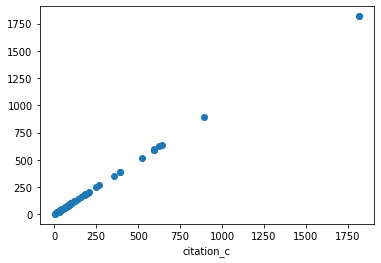

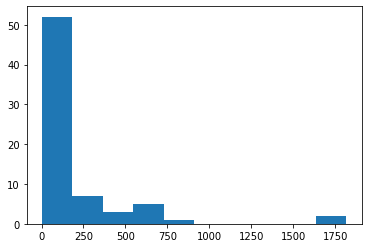

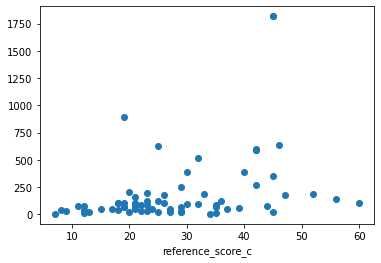

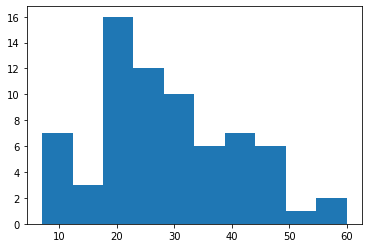

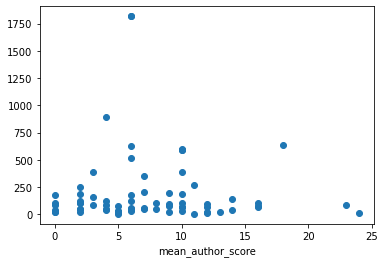

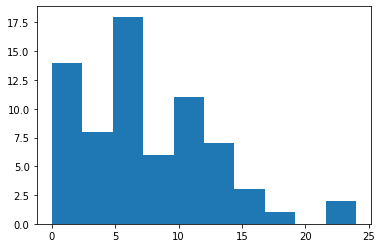

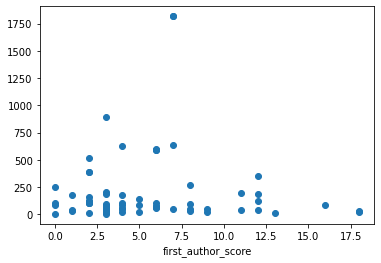

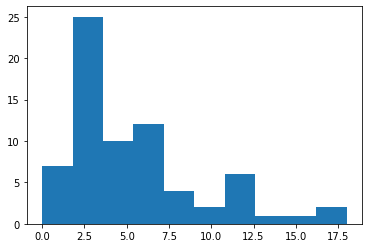

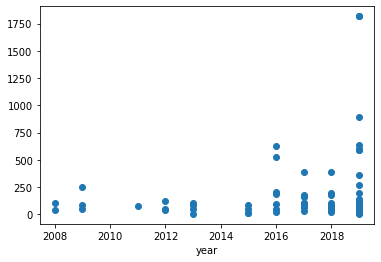

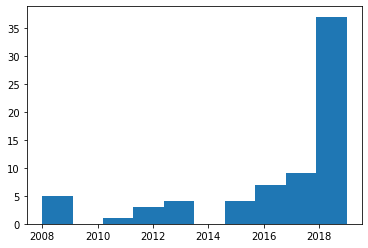

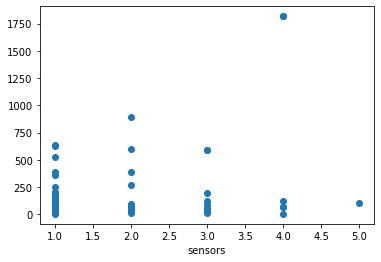

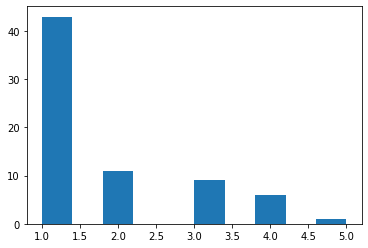

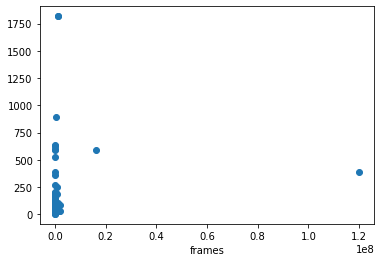

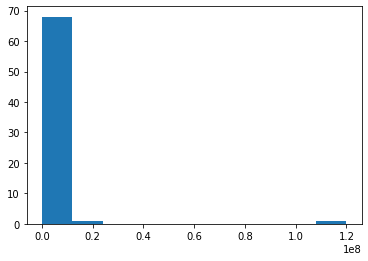

120000000.0


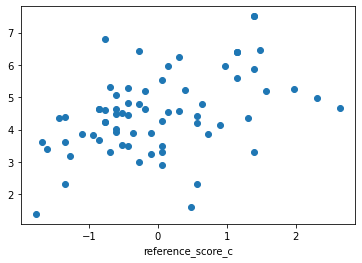

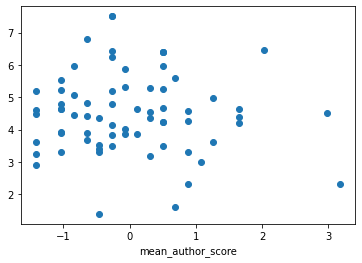

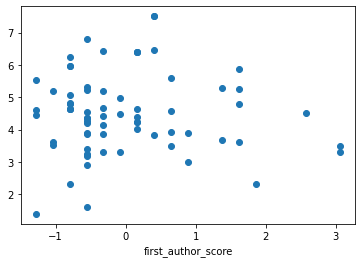

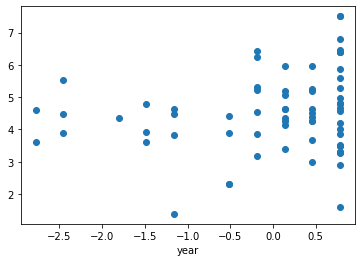

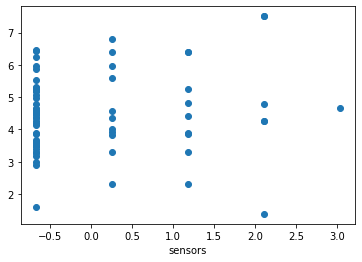

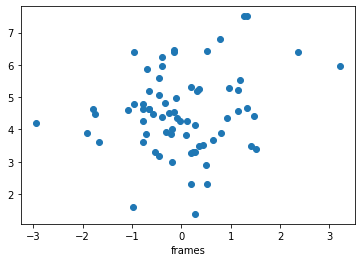

                            OLS Regression Results                            
Dep. Variable:             citation_c   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     3.439
Date:                Fri, 23 Dec 2022   Prob (F-statistic):            0.00358
Time:                        15:45:01   Log-Likelihood:                -103.41
No. Observations:                  70   AIC:                             222.8
Df Residuals:                      62   BIC:                             240.8
Df Model:                           7                                         
Covariance Type:                  HC1                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
reference_score_c       0.5622    

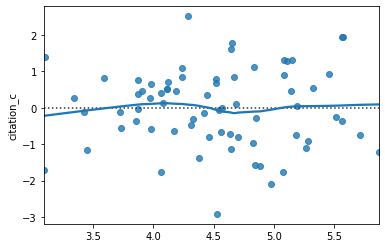

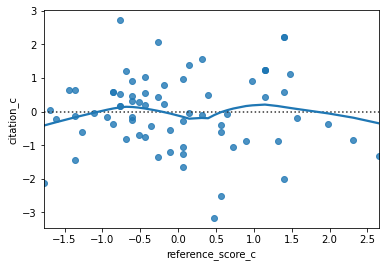

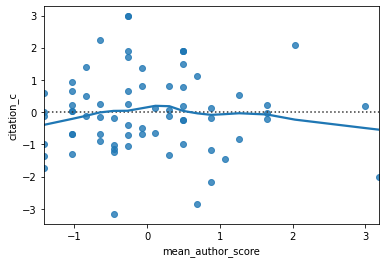

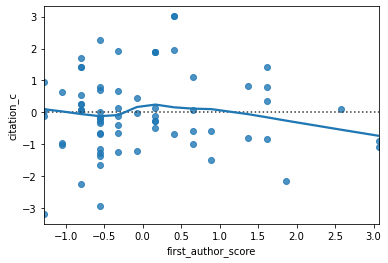

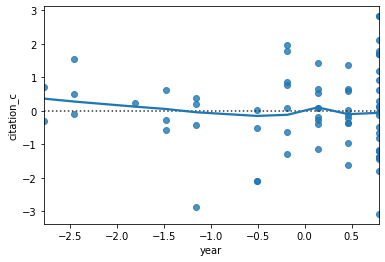

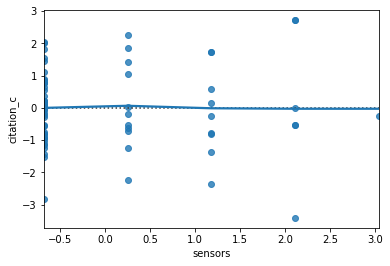

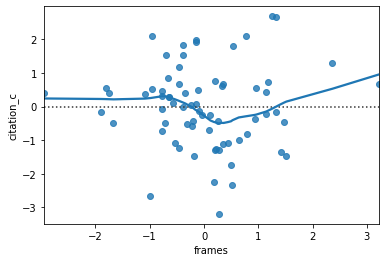

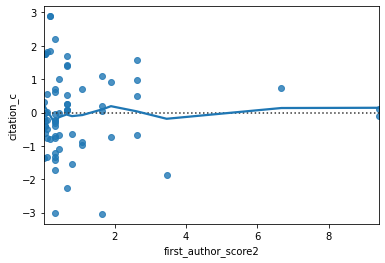

102546.8258348012


In [383]:
df = create_modelling_df_no_altmetrics(retrieved_data, 3, 0, 3)
modelling_df = convert_data(df)
modelling_df_normalized = normalize(modelling_df)
res, fitted_y, y_ols, x = modelling(modelling_df_normalized)
print(sm.tools.eval_measures.mse(np.exp(fitted_y)-1, np.exp(y_ols))-1)
# df = create_modelling_df(retrieved_data, 3, 0, 3)
# modelling_df = convert_data(df)
# modelling_df.corr()

100%|██████████| 185/185 [00:01<00:00, 125.56it/s]


Missing Data: 76
(109, 8)
(79, 8)


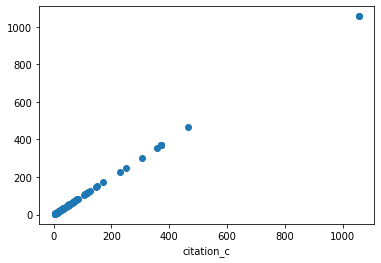

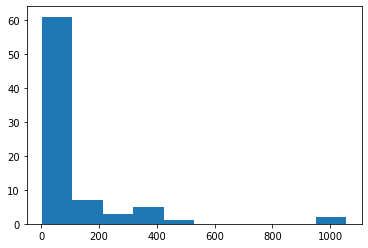

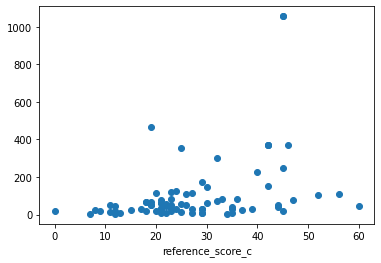

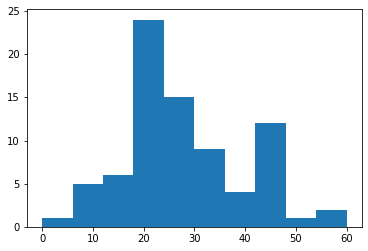

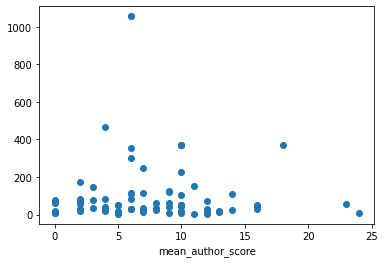

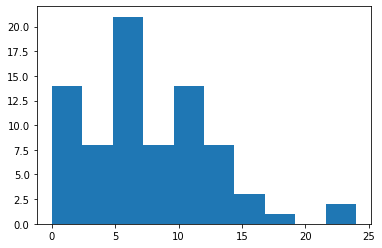

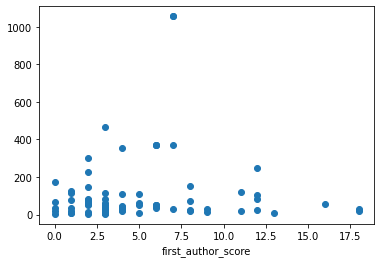

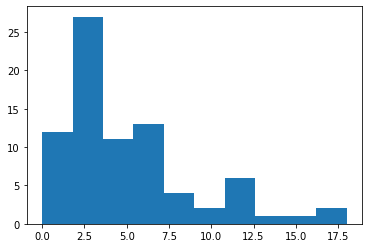

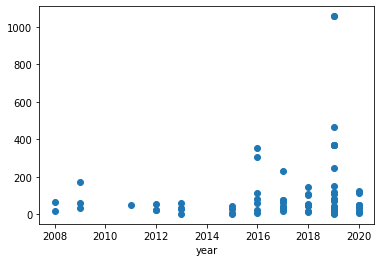

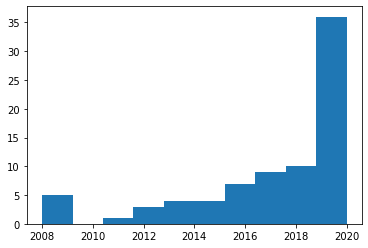

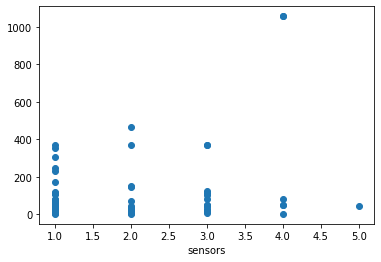

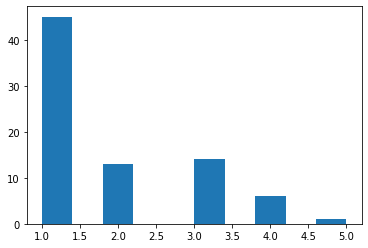

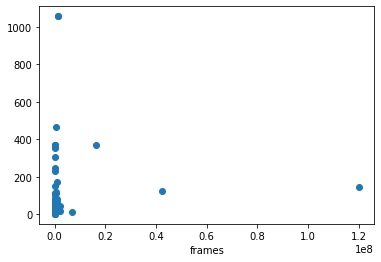

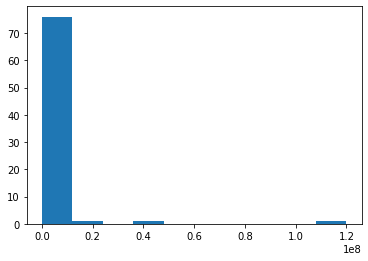

120000000.0


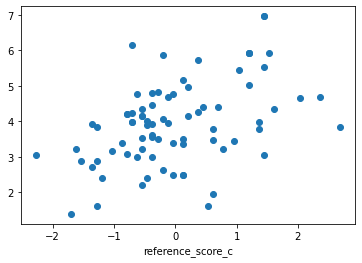

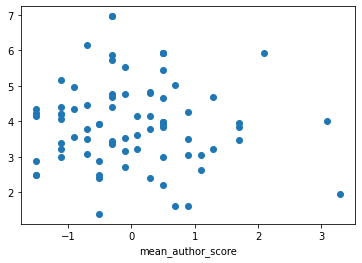

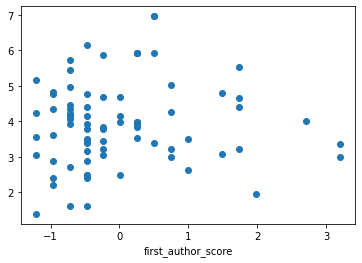

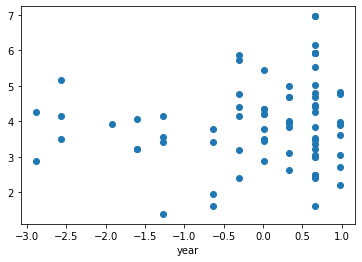

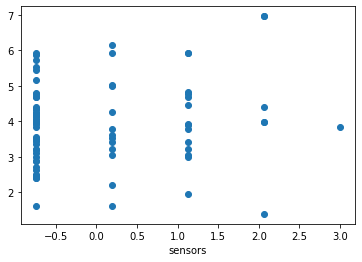

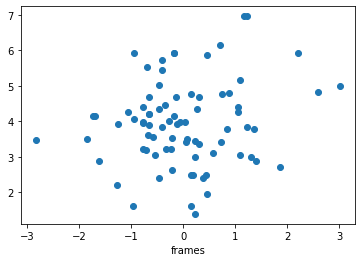

                            OLS Regression Results                            
Dep. Variable:             citation_c   R-squared:                       0.255
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     3.314
Date:                Fri, 23 Dec 2022   Prob (F-statistic):            0.00415
Time:                        15:45:05   Log-Likelihood:                -113.44
No. Observations:                  79   AIC:                             242.9
Df Residuals:                      71   BIC:                             261.8
Df Model:                           7                                         
Covariance Type:                  HC1                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
reference_score_c       0.5014    

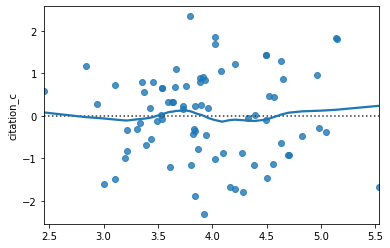

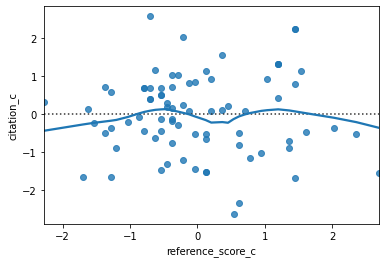

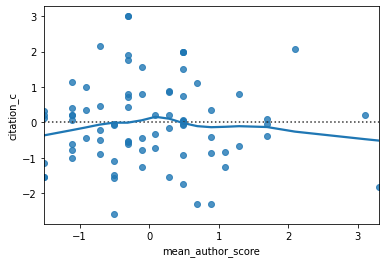

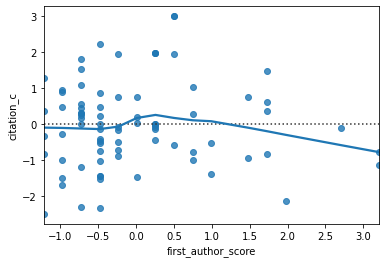

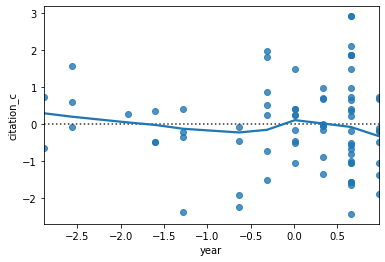

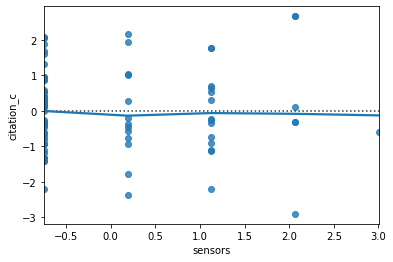

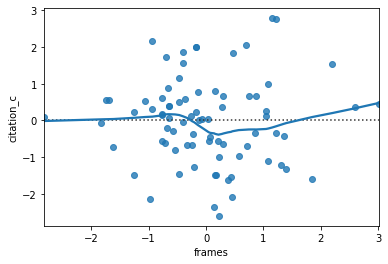

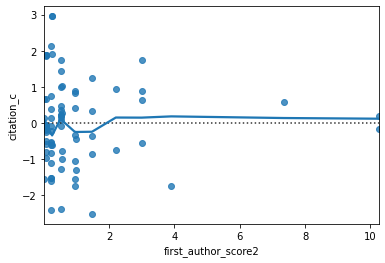

30271.415011622175


In [384]:
df = create_modelling_df_no_altmetrics(retrieved_data, 3, 0, 2)
modelling_df = convert_data(df)
modelling_df_normalized = normalize(modelling_df)
res, fitted_y, y_ols, x = modelling(modelling_df_normalized)
print(sm.tools.eval_measures.mse(np.exp(fitted_y)-1, np.exp(y_ols))-1)

In [354]:
#modelling_df.corr()

,citation_c,reference_score_c,mean_author_score,first_author_score,year,sensors,frames
citation_c,1.000000,0.436015,-0.050428,-0.024005,0.153341,0.078583,0.101900
reference_score_c,0.436015,1.000000,0.220325,0.117218,0.435081,0.280634,0.182653
mean_author_score,-0.050428,0.220325,1.000000,0.385037,0.351181,0.067108,-0.069002
first_author_score,-0.024005,0.117218,0.385037,1.000000,0.287700,0.172232,0.096502
year,0.153341,0.435081,0.351181,0.287700,1.000000,0.223370,0.302109
sensors,0.078583,0.280634,0.067108,0.172232,0.223370,1.000000,0.299065
frames,0.101900,0.182653,-0.069002,0.096502,0.302109,0.299065,1.000000


In [ ]:
Making Citation Predictor

In [ ]:
import xgboost as xgb

In [ ]:
#https://www.statalist.org/forums/forum/general-stata-discussion/general/1440566-statistically-significant-squared-term-but-insignificant-level-term
sm.regression.linear_model.RegressionResults.f_test()


"Second, the linear effect in a quadratic relationship must not be significant if the quadratic effect is significant.
A good read for non-linear relationships is
Haans, R. F., Pieters, C., & He, Z. L. (2016). Thinking about U: Theorizing and testing U‐and inverted U‐shaped relationships in strategy research. Strategic Management Journal, 37(7), 1177–1195."

Added  req4Seasons.json
Added  reqA2D2.json
Added  reqA3D.json
Added  reqA9.json
Added  reqaiMotive.json
Added  reqAmodalCityscapes.json
Added  reqAMUSE.json
Added  reqApolloScape.json
Added  reqArgoverse1Stereo.json
Added  reqArgoverse3DTracking.json
Added  reqArgoverseMotionForecasting.json
Added  reqAugKITTI.json
Added  reqAutomatumOpenHighway.json
Added  reqAutonomousPlatformInertial.json
Added  reqBayArea.json
Added  reqBDD100k.json
Added  reqBeyondPASCAL.json
Added  reqBLVD.json
Added  reqBoreas.json
Added  reqBoschSmallTrafficLightsDataset.json
Added  reqBoschTL.json
Added  reqBoxCars116k.json
Added  reqBoxy.json
Added  reqBrain4Cars.json
Added  reqCADC.json
Added  reqCADP.json
Added  reqCaltechLanes.json
Added  reqCaltechPedestrian.json
Added  reqCamVid.json
Added  reqCarlaScenes.json
Added  reqCARLAWildLifeCWL.json
Added  reqCARRADA.json
Added  reqCars.json
Added  reqCCSAD.json
Added  reqCityscapes3D.json
Added  reqCityscapesDVPS.json
Added  reqCODA.json
Added  reqComma2k19.js

100%|██████████| 185/185 [00:01<00:00, 112.33it/s]


Missing Data: 76
(109, 8)
(70, 8)


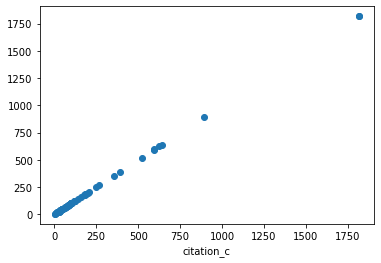

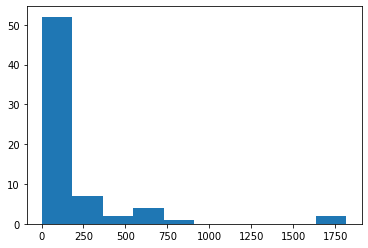

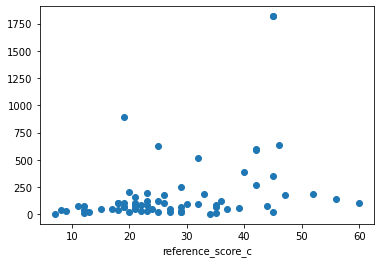

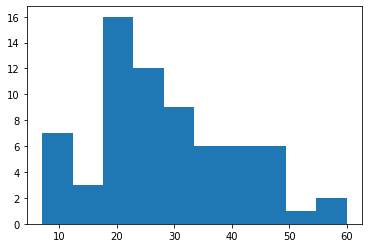

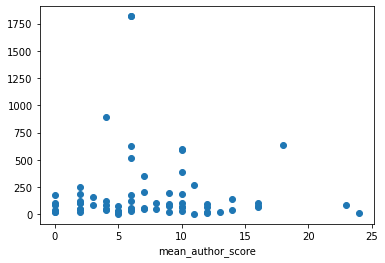

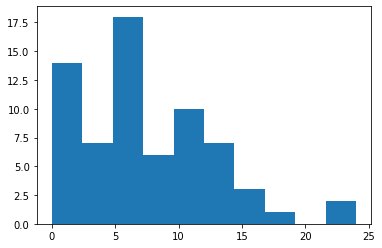

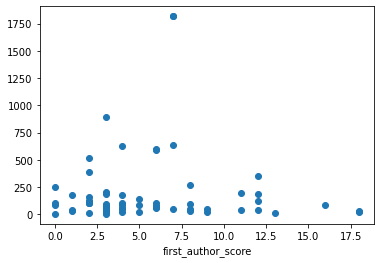

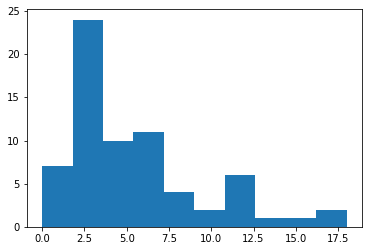

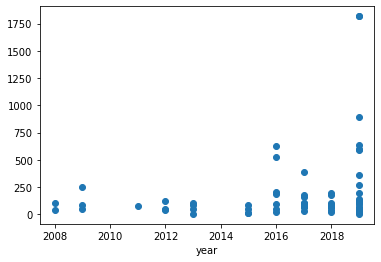

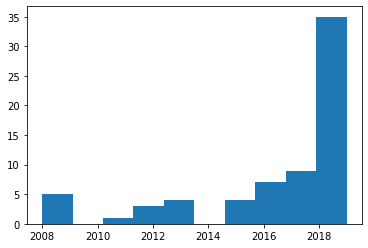

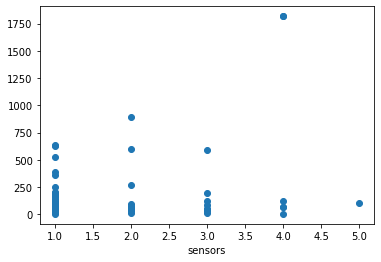

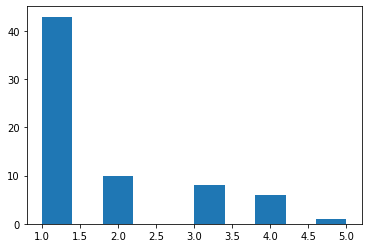

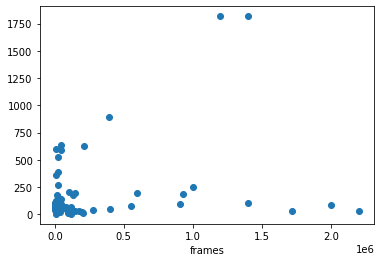

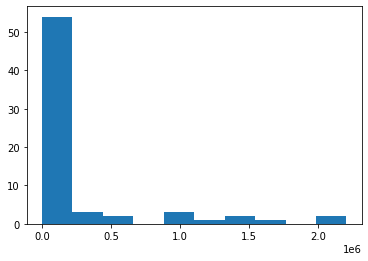

2206106.0


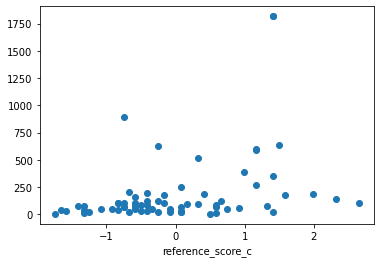

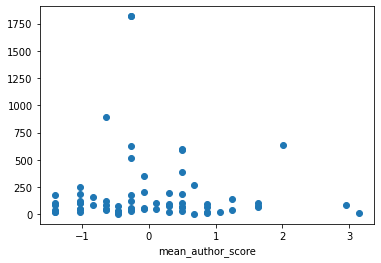

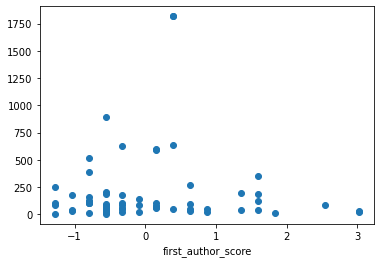

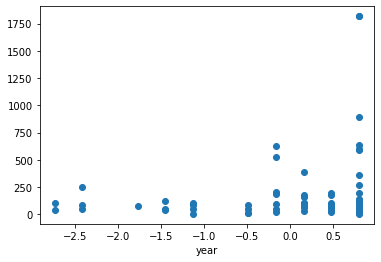

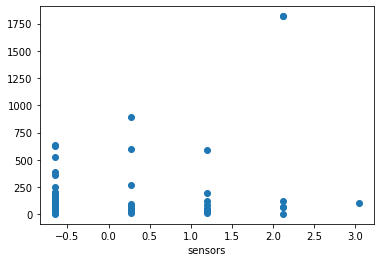

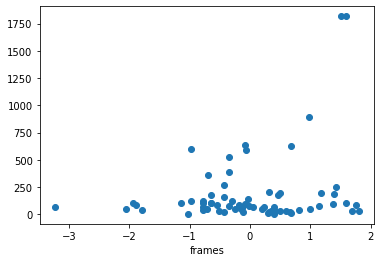

Optimization terminated successfully.
         Current function value: 107.734521
         Iterations 6
                          Poisson Regression Results                          
Dep. Variable:             citation_c   No. Observations:                   68
Model:                        Poisson   Df Residuals:                       61
Method:                           MLE   Df Model:                            6
Date:                Fri, 23 Dec 2022   Pseudo R-squ.:                  0.3261
Time:                        15:22:08   Log-Likelihood:                -7325.9
converged:                       True   LL-Null:                       -10872.
Covariance Type:                  HC1   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
reference_score_c      0.4042      0.156      2.594      0.009       0.099       0.710
mea

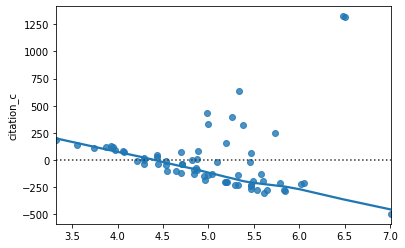

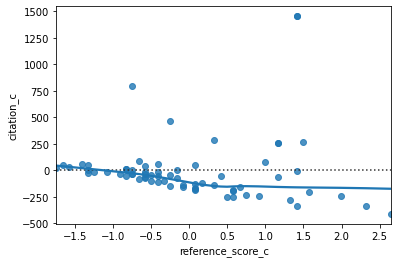

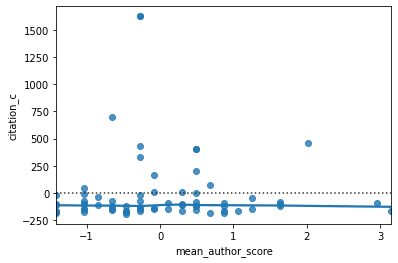

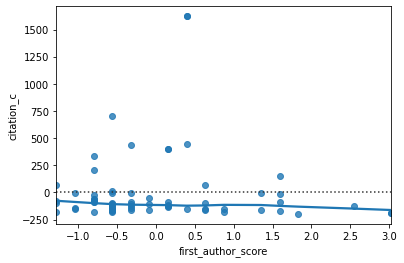

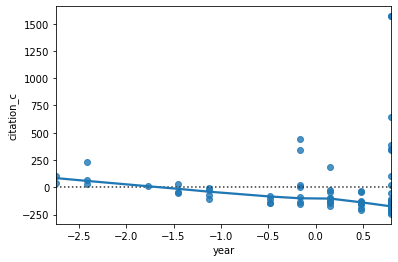

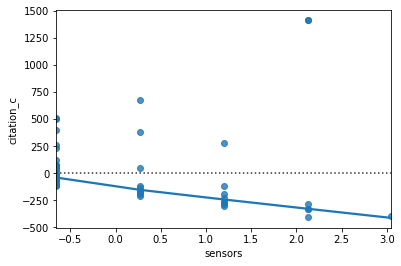

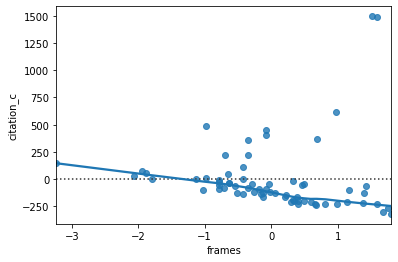

146112.9256004049
1.2434497875801753e-14


In [344]:
def convert_data_poisson(df, drop='citations_citations_c', dependent_var='citation_c'):
    replacement = df.at['Street Learn', 'frames'].replace(',', '')
    #print(replacement)
    df.at['Street Learn', 'frames'] = replacement
    modelling_df = df
    modelling_df = modelling_df.drop(['BDD100k', 'Argoverse Motion Forecasting'], axis=0)
    modelling_df = modelling_df.drop([drop], axis=1)
    for idx_column, col in enumerate(modelling_df.columns):
        modelling_df[col] = modelling_df[col].astype("float")
    for idx, variable in enumerate(modelling_df):
        plt.scatter(modelling_df[variable], modelling_df[dependent_var])
        plt.xlabel(list(modelling_df.columns)[idx])
        plt.show()
        plt.hist(modelling_df[variable])
        plt.show()
    print(modelling_df.frames.max())
    modelling_df.frames = np.log(modelling_df.frames + 1)
    return modelling_df

def poisson(modelling_df, dependent_var='citation_c'):
    independent_vars = modelling_df.drop([dependent_var], axis=1)
    X = add_constant(independent_vars)
    y = modelling_df[dependent_var]
    mod = Poisson(y, independent_vars.assign(intercept=1))
    res = mod.fit(cov_type='HC1')
    print(res.summary())
    test = sm.stats.diagnostic.het_breuschpagan(res.resid, res.model.exog)
    print('test', test)
    vif = pd.Series([variance_inflation_factor(X.values, i)
               for i in range(X.shape[1])],
              index=X.columns)
    print(vif)

    fitted_y = res.fittedvalues
    plot = sns.residplot(x=fitted_y, y=modelling_df[dependent_var], data=modelling_df, lowess=True)
    plt.show()
    for variable in independent_vars:
        plot = sns.residplot(x=independent_vars[variable], y=modelling_df[dependent_var], data=modelling_df, lowess=True)
        plt.show()
    return res, fitted_y, y, independent_vars

wd = os.getcwd()
wd = wd.replace('.ipynb_checkpoints', '')
directory = os.path.join(wd, 'data', 'requests5')
retrieved_data =  []
for file in os.listdir(directory):
    with open(os.path.join(directory, file), "r") as j:
        a = json.loads(j.read())
        retrieved_data.append(a)
        print('Added ', file)
#retrieved_data
retrieved_data = sorted(retrieved_data, key=itemgetter('citationCount'), reverse=True)

df = create_modelling_df_no_altmetrics(retrieved_data, 3, 0, 3)
modelling_df = convert_data_poisson(df)
modelling_df_normalized = normalize(modelling_df)
res, fitted_y, y, x = poisson(modelling_df)
print(sm.tools.eval_measures.mse(fitted_y, y))
print(sm.tools.eval_measures.mse(y, np.exp(y_ols))-1)

In [ ]:
# plt.hist(df.citation_c, bins=30)
# plt.show()

In [ ]:
wd = os.getcwd()
wd = wd.replace('.ipynb_checkpoints', '')
directory = os.path.join(wd, 'data', 'requests')
retrieved_data =  []
for file in os.listdir(directory):
    with open(os.path.join(directory, file), "r") as j:
        a = json.loads(j.read())
        retrieved_data.append(a)
        print('Added ', file)
#retrieved_data
retrieved_data = sorted(retrieved_data, key=itemgetter('citationCount'), reverse=True)

In [ ]:
yr = 2022
array = np.empty([len(retrieved_data), 6])
array[:] = np.nan
names = []
for paper_idx, o_paper in enumerate(tqdm(retrieved_data)):
    scorer = scoring(o_paper, 200, yr, yr)
    reference = scorer.reference_score()
    citations_citations = scorer.citations_citations_score()
    citations = scorer.just_citations()
    ls_author_scores = []
    names.append(o_paper['id'])
    for author_number, author in enumerate(o_paper['paperInfo']['authors']):
        single_author_score = scorer.citations_single_author_score(author_number)
        ls_author_scores.append(single_author_score)
    author = np.mean(ls_author_scores)
    try:
        score = o_paper['altmetrics'][0]['score']
        total_readers = o_paper['altmetrics'][3]['total_readers']
    except:
        percentile = float("NaN")
        total_readers = float("NaN")
    array[paper_idx][:] = [citations, citations_citations, total_readers, score, reference, author,]
array

In [ ]:
spider_web = pd.DataFrame(array, columns=['citations', 'citations_citations', 'total_readers', 'score', 'reference', 'author']).set_axis(names)
spider_web['Altmetric'] = spider_web.score.rank(pct = True)
spider_web['cit'] = spider_web.citations.rank(pct = True)
spider_web['h-cit'] = spider_web.citations_citations.rank(pct = True)
spider_web['readers'] = spider_web.total_readers.rank(pct = True)
spider_web['refs'] = spider_web.reference.rank(pct = True)
spider_web['authors'] = spider_web.author.rank(pct = True)
spider_web

In [ ]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

N = 6
theta = radar_factory(N, frame='polygon')
values = [[], [], [], []]
web_names = [[], [], [], []]
data = []
k = 0
for i in range(12):
    row = (spider_web.iloc[i][-6:])
    if i%3 == 0 and i != 0:
        k += 1
    print(k)
    values[k].append( list(row))
    web_names[k].append(row.name)

dimension_names = []
for name in enumerate(list(spider_web.columns[-6:])):
    #print(name[1])
    dimension_names.append(name[1].replace('author', '   author'))
data = [dimension_names, ('', web_names[0], values[0]), ('', web_names[1], values[1]), ('', web_names[2], values[2]), ('', web_names[3], values[3])]

#print(data)
spoke_labels = data.pop(0)

fig, axs = plt.subplots(figsize=(16, 4), nrows=1, ncols=4,
                        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.8, hspace=0.0, top=0.95, bottom=0.05)

# Plot the four cases from the example data on separate axes
colors = ['#648fff', '#dc267f', '#ffb000'] #['#648fff', '#785ef0', '#dc267f', '#fe6100', '#ffb000']
for ax, (title, label, case_data) in zip(axs.flat, data):
    ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
    ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                 horizontalalignment='center', verticalalignment='center')
    for d, color in zip(case_data, colors):
        ax.plot(theta, d, color=color)
        ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
    ax.set_varlabels(spoke_labels)
    ax.legend(label, loc=(0.75, -0.15),
                          labelspacing=0.1, fontsize='small')

# add legend relative to top-left plot
#labels = ('Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5')
#legend = axs[0, 0].legend(labels, loc=(0.9, .95),
#                          labelspacing=0.1, fontsize='small')

#fig.text(0.5, 0.7, 'Influence of Successful Papers',
#         horizontalalignment='center', color='black', weight='bold',
#         size='large')
plt.savefig('output/spider_web_at.pdf', bbox_inches='tight')
plt.show()

In [ ]:
N = 6
theta = radar_factory(N, frame='polygon')
'''values = [[], [], [], []]
web_names = [[], [], [], []]
for i in range(2):
    row = (spider_web.iloc[i][-6:])
    values[0].append(list(row))
    web_names[0].append(row.name)'''

values_21 = [[], []]
web_names_21 = [[], []]
for index, i in enumerate(['Waymo Open Motion', 'SemKITTI-DVPS', 'Cityscapes-DVPS', 'ONCE', 'MAVD Multimodal Audio-Visual Detection', 'MOTSynth', 'RoadAnomaly21']):
    # top 6 ['Waymo Open Motion', 'SemKITTI-DVPS', 'Cityscapes-DVPS', 'ONCE', 'RoadAnomaly21', 'MOTSynth', 'RoadAnomaly21'] #'SemKITTI-DVPS', 'Cityscapes-DVPS' are the same
    if i == 'SemKITTI-DVPS':
        continue
    row = (spider_web.loc[i][-6:])
    if index <= 3:
        values_21[0].append(list(row))
        web_names_21[0].append(row.name)
    else:
        values_21[1].append(list(row))
        web_names_21[1].append(row.name)
dimension_names = []

for name in enumerate(list(spider_web.columns[-6:])):
    #print(name[1])
    dimension_names.append(name[1].replace('_', '\n'))
data = [dimension_names, ('', web_names_21[0], values_21[0]), ('', web_names_21[1], values_21[1])]

print(data)
spoke_labels = data.pop(0)

fig, axs = plt.subplots(figsize=(10, 4), nrows=1, ncols=2,
                        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.2, hspace=0.10, top=0.9, bottom=0.1)

# Plot the four cases from the example data on separate axes
colors = ['#648fff', '#dc267f', '#ffb000'] #['#648fff', '#785ef0', '#dc267f', '#fe6100', '#ffb000']
for ax, (title, label, case_data) in zip(axs.flat, data):
    ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
    '''ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.4),
                 horizontalalignment='center', verticalalignment='center')'''
    a = 0
    for d, color in zip(case_data, colors):
        ax.plot(theta, d, color=color)
        ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
        a += 1
    ax.set_varlabels(spoke_labels)
    ax.legend(label, loc=(0.7, -0.1),
                          labelspacing=0.1, fontsize='small')

# add legend relative to top-left plot
#labels = ('Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5')
#legend = axs[0, 0].legend(labels, loc=(0.9, .95),
#                          labelspacing=0.1, fontsize='small')

plt.savefig('output/spider_web_at_best_of_21.pdf', bbox_inches='tight')
plt.show()

In [ ]:
same_start_year = False
if same_start_year:
    references_array = np.empty([len(retrieved_data), 15])
    citations_array = np.empty([len(retrieved_data), 15])
    citations_citations_array = np.empty([len(retrieved_data), 15])
    author_array = np.empty([len(retrieved_data), 15])

    references_array[:] = np.nan
    citations_array[:] = np.nan
    citations_citations_array[:] = np.nan
    author_array[:] = np.nan
    names = []
    for paper_idx, o_paper in enumerate(tqdm(retrieved_data)):
        names.append(o_paper['id'])
        for index in range(16):
            yr = o_paper['paperInfo']['year'] + index
            if yr > 2022:
                break
            scorer = scoring(o_paper, 50, index, index)

            ls_author_scores = []
            for author_number, author in enumerate(o_paper['paperInfo']['authors']):
                single_author_score = scorer.citations_single_author_score(author_number)
                ls_author_scores.append(single_author_score)
            author_array[paper_idx, index] = np.mean(ls_author_scores)
            references_array[paper_idx, index] = scorer.reference_score()
            citations_array[paper_idx, index] = scorer.just_citations()
            citations_citations_array[paper_idx, index] = scorer.citations_citations_score()

In [ ]:
if not same_start_year:
    references_array = np.empty([len(retrieved_data), 15])
    citations_array = np.empty([len(retrieved_data), 15])
    citations_citations_array = np.empty([len(retrieved_data), 15])
    author_array = np.empty([len(retrieved_data), 15])
    citations_citations_sum_array = np.empty([len(retrieved_data), 15])
    references_array[:] = np.nan
    citations_array[:] = np.nan
    citations_citations_array[:] = np.nan
    author_array[:] = np.nan
    citations_citations_sum_array[:] = np.nan
    names = []
    for paper_idx, o_paper in enumerate(tqdm(retrieved_data)):
        names.append(o_paper['id'])
        for index in range(14, 0, -1): #index = 16 = year 2022
            dist = 2008+ index-o_paper['paperInfo']['year']
            if dist < 0:
                break
            scorer = scoring(o_paper, 50, dist, dist)

            ls_author_scores = []
            for author_number, author in enumerate(o_paper['paperInfo']['authors']):
                single_author_score = scorer.citations_single_author_score(author_number)
                ls_author_scores.append(single_author_score)
            author_array[paper_idx, index] = np.mean(ls_author_scores)
            references_array[paper_idx, index] = scorer.reference_score()
            citations_array[paper_idx, index] = scorer.just_citations()
            citations_citations_array[paper_idx, index] = scorer.citations_citations_score()
            citations_citations_sum_array[paper_idx, index] = scorer.citations_citations_sum()


In [ ]:
author_df = pd.DataFrame(author_array).set_axis(names)
references_df = pd.DataFrame(references_array).set_axis(names)
citations_df = pd.DataFrame(citations_array).set_axis(names)
citations_citations_df = pd.DataFrame(citations_citations_array).set_axis(names)
citations_citations_sum_df = pd.DataFrame(citations_citations_sum_array).set_axis(names)
for i in range(15):
    author_df.iloc[:, i] = author_df.iloc[:, i].rank(pct = True)
    references_df.iloc[:, i] = references_df.iloc[:, i].rank(pct = True)
    citations_df.iloc[:, i] = citations_df.iloc[:, i].rank(pct = True)
    citations_citations_df.iloc[:, i] = citations_citations_df.iloc[:, i].rank(pct = True)
author_df

In [ ]:
percentile_scores = {"authors": author_df, "references": references_df, "citations": citations_df, "citations_citations": citations_citations_df}

In [ ]:
def relevance_score(scores, alpha=0.25, beta=0.25, gamma=0.25, theta=0.25, relative_c2=False): #Todo sum of weights = 1
    result = scores['references']*alpha + scores['authors']*beta + scores['citations']*gamma + scores['citations_citations']*theta
    if relative_c2:
        result = scores['citations_citations']/scores['citations']
    return result

In [ ]:
relevance_scores = relevance_score(percentile_scores).round(3)
relevance_scores.columns = [*range(2008, 2023)]


In [ ]:
relevance_scores = relevance_scores[pd.notna(relevance_scores[2019])]
relevance_scores = relevance_scores.sort_values([2022], ascending=[False])
relevance_scores.to_csv('output/infSco_equal_weigths.csv', header=[*range(2008, 2023)])

In [ ]:
relevance_scores.duplicated(subset=[2022])

In [ ]:
relevance_scores = relevance_score(percentile_scores, alpha=0, beta=0, gamma=0.5, theta=0.5)

In [ ]:
colors=['#648fff', '#785ef0', '#dc267f', '#fe6100', '#ffb000', '#A740AE']
datasets = ['KITTI','Cars Dataset', 'Synthia', 'Waymo Open Motion', 'Cityscapes-DVPS', 'ONCE']
interest = relevance_scores.loc[datasets]

In [ ]:
ws = [('citations', [0, 0, 1, 0]), ('equal weights', [0.25, 0.25, 0.25, 0.25]), ('citations of citations', [0, 0, 0, 1]),  ('references, authors, citations', [0.33, 0.33, 0.33, 0])]
'''w = ws[0]
relevance_scores = relevance_score(percentile_scores, alpha=w[0], beta=w[1], gamma=w[2], theta=w[3])
for i_row, row in enumerate(datasets):
    plt.plot(relevance_scores.loc[row], label=relevance_scores.loc[row].name, color=colors[i_row])
plt.legend(loc='best')
plt.show()'''
fig, axs = plt.subplots(figsize=(14, 8), nrows=2, ncols=2)
fig.subplots_adjust(wspace=0.2, hspace=0.2, top=0.95, bottom=0.1)

first = True
for ax, (scenario_name, w) in zip(axs.flat, ws):
    relevance_scores = relevance_score(percentile_scores, alpha=w[0], beta=w[1], gamma=w[2], theta=w[3])
    for i_row, row in enumerate(datasets):
        ax.plot([*range(2008, 2023)], relevance_scores.loc[row], label=relevance_scores.loc[row].name, color=colors[i_row])
    ax.set(xlim=(2014, 2022), ylim=(0, 1.04), xticks=[*range(2014, 2023, 2)], xlabel='years', ylabel=scenario_name)
    if first:
        ax.legend(datasets, loc='lower center', labelspacing=0.1, fontsize='medium')
        first = False
plt.savefig('output/influence_scores.pdf')
plt.show()

In [ ]:
ws = [('citations', [0, 0, 1, 0]), ('equal weights', [0.25, 0.25, 0.25, 0.25]), ('citations of citations', [0, 0, 0, 1]),  ('references, authors, citations', [0.33, 0.33, 0.33, 0])]
'''w = ws[0]
relevance_scores = relevance_score(percentile_scores, alpha=w[0], beta=w[1], gamma=w[2], theta=w[3])
for i_row, row in enumerate(datasets):
    plt.plot(relevance_scores.loc[row], label=relevance_scores.loc[row].name, color=colors[i_row])
plt.legend(loc='best')
plt.show()'''
fig, axs = plt.subplots(figsize=(14, 8), nrows=2, ncols=2)
fig.subplots_adjust(wspace=0.2, hspace=0.2, top=0.95, bottom=0.1)

first = True
for ax, (scenario_name, w) in zip(axs.flat, ws):
    relevance_scores = relevance_score(percentile_scores, alpha=w[0], beta=w[1], gamma=w[2], theta=w[3])
    for i_row, row in enumerate(list(relevance_scores.index.values)):
        #print(relevance_scores.loc[row])
        ax.plot([*range(2008, 2023)], relevance_scores.iloc[i_row], label=relevance_scores.iloc[i_row])
    ax.set(xlim=(2014, 2022), ylim=(0, 1.04), xticks=[*range(2014, 2023, 2)], xlabel='years', ylabel=scenario_name)
    if first:
        ax.legend(datasets, loc='lower center', labelspacing=0.1, fontsize='medium')
        first = False
plt.savefig('output/influence_scores_3.pdf')
plt.show()

In [ ]:
a =
ws = [('citations', [0, 0, 1, 0]), ('equal weights', [0.25, 0.25, 0.25, 0.25]), ('citations of citations', [0, 0, 0, 1]),  ('references, authors, citations', [0.33, 0.33, 0.33, 0])]
'''w = ws[0]
relevance_scores = relevance_score(percentile_scores, alpha=w[0], beta=w[1], gamma=w[2], theta=w[3])
for i_row, row in enumerate(datasets):
    plt.plot(relevance_scores.loc[row], label=relevance_scores.loc[row].name, color=colors[i_row])
plt.legend(loc='best')
plt.show()'''
fig, axs = plt.subplots(figsize=(14, 8), nrows=2, ncols=2)
fig.subplots_adjust(wspace=0.2, hspace=0.2, top=0.95, bottom=0.1)

first = True
for ax, (scenario_name, w) in zip(axs.flat, ws):
    relevance_scores = relevance_score(percentile_scores, alpha=w[0], beta=w[1], gamma=w[2], theta=w[3])
    for i_row, row in enumerate(list(relevance_scores.index.values)):
        #print(relevance_scores.iloc[i_row])
        for i, score in enumerate(relevance_scores.iloc[i_row]):
            if score is not None:
                ax.scatter((2008+i), score, label=relevance_scores.iloc[i_row], alpha=0.3)
    ax.set(xlim=(2014, 2022), ylim=(0, 1.04), xticks=[*range(2014, 2023, 2)], xlabel='years', ylabel=scenario_name)
    if first:
        ax.legend(datasets, loc='lower center', labelspacing=0.1, fontsize='medium')
        first = False
plt.savefig('output/influence_scores_3.pdf')
plt.show()

In [ ]:
ws = [('equal weights', [0.25, 0.25, 0.25, 0.25])]
ax = plt.subplot()
#ax.subplots_adjust(wspace=0.2, hspace=0.2, top=0.95, bottom=0.1)

first = True
for (scenario_name, w) in ws:
    relevance_scores = relevance_score(percentile_scores, alpha=w[0], beta=w[1], gamma=w[2], theta=w[3])
    for i_row, row in enumerate(list(relevance_scores.index.values)):
        #print(relevance_scores.iloc[i_row])
        for i, score in enumerate(relevance_scores.iloc[i_row]):
            if score is not None:
                ax.scatter((2008+i), score, label=relevance_scores.iloc[i_row], alpha=0.3)
    ax.set(xlim=(2008, 2023), ylim=(0, 1.04), xticks=[*range(2008, 2024, 2)], xlabel='years', ylabel=scenario_name)
    #if first:
    #    ax.legend(datasets, loc='lower center', labelspacing=0.1, fontsize='medium')
    #    first = False
plt.savefig('output/influence_scores_3.pdf')
plt.show()

In [ ]:
ws = [('citations', [0, 0, 1, 0]), ('h-index of citations', [0, 0, 0, 1]), ('references', [1, 0, 0, 0]), ('authors', [0, 1, 0, 0]), ('equal weights', [0.25, 0.25, 0.25, 0.25]), ('early post release', [0.5, 0, 0.5, 0])]
fig, axs = plt.subplots(figsize=(20, 8), nrows=2, ncols=3)
fig.subplots_adjust(wspace=0.2, hspace=0.2, top=0.8, bottom=0.2)

first = True
for ax, (scenario_name, w) in zip(axs.flat, ws):
    relevance_scores = relevance_score(percentile_scores, alpha=w[0], beta=w[1], gamma=w[2], theta=w[3])
    for i_row, row in enumerate(datasets):
        ax.plot([*range(2008, 2023)], relevance_scores.loc[row], label=relevance_scores.loc[row].name, color=colors[i_row])
    ax.set(xlim=(2012, 2022), ylim=(0, 1.04), xticks=[*range(2012, 2023, 2)], xlabel='years', ylabel=scenario_name)
    if first:
        ax.legend(datasets, loc='lower center', labelspacing=0.1, fontsize='small')
        first = False
plt.savefig('output/influence_scores2.pdf', bbox_inches='tight')
plt.show()

In [ ]:
colors=['#648fff', '#785ef0', '#dc267f', '#fe6100', '#ffb000', '#E7581E']
ws = [('citations', [0, 0, 1, 0]), ('citations of citations', [0, 0, 0, 1])]
fig, axs = plt.subplots(figsize=(18, 4), nrows=1, ncols=3)
fig.subplots_adjust(wspace=0.2, hspace=0, top=0.8, bottom=0.2)
datasets = ['KITTI', 'Cars Dataset', 'CamVid', 'DIPLECS Autonomous Driving Datasets', 'Illumination Changes in a day', 'AMUSE']
first = True
for ax, (scenario_name, w) in zip(axs.flat, ws):
    relevance_scores = relevance_score(percentile_scores, alpha=w[0], beta=w[1], gamma=w[2], theta=w[3], relative_c2=False)
    for i_row, row in enumerate(datasets):
        ax.plot([*range(2008, 2023)], relevance_scores.loc[row], label=relevance_scores.loc[row].name, color=colors[i_row])
    ax.set(xlim=(2014, 2022), ylim=(0, 1.04), xticks=[*range(2014, 2023, 2)], xlabel='years', ylabel=scenario_name)
    if first:
        ax.legend(datasets, loc='best', labelspacing=0.1, fontsize='small')
        first = False
#plt.savefig('output/influence_scores2.pdf')
plt.show()

In [ ]:
colors=['#648fff', '#785ef0', '#dc267f', '#fe6100', '#ffb000', '#A740AE']
datasets = ['KITTI','Synthia', 'nuScenes', 'Waymo Open Motion', 'Cityscapes-DVPS', 'ONCE']
interest = relevance_scores.loc[datasets]

In [ ]:
author_df = pd.DataFrame(author_array).set_axis(names)
references_df = pd.DataFrame(references_array).set_axis(names)
citations_df = pd.DataFrame(citations_array).set_axis(names)
citations_citations_df = pd.DataFrame(citations_citations_array).set_axis(names)
citations_citations_sum_df = pd.DataFrame(citations_citations_sum_array).set_axis(names)

In [ ]:
df = citations_citations_sum_df.iloc[:144]
df['citations_citations_rank'] = citations_citations_sum_df.iloc[:144][14]#/citations_df.iloc[:144][14]).rank(pct = True)
df['citation_rank'] = citations_df.iloc[:144][14] #.rank(pct = True)
plt.scatter(df.citation_rank, df.citations_citations_rank, color='#648fff')
plt.xlabel('(citations)')
plt.xlim(0, 1000)
plt.ylabel('(citations of citations)')
plt.savefig('output/citations_of_citations_per_citation.pdf')
plt.show()

In [ ]:
from scipy.stats import pearsonr
pearsonr(df.citation_rank, df.citations_citations_rank)
#correlation coeff, p-value

In [ ]:
x = pd.DataFrame(df.citation_rank)
mod = sm.OLS(df.citations_citations_rank, x.assign(intercept=1))
res = mod.fit()
print(res.summary())

In [ ]:
score  = (df.citations_citations_rank - res.fittedvalues).rank(pct=True)

In [ ]:
plt.scatter(df.citation_rank, list(score), alpha=1, s=4)
plt.xlim(0, 100)
plt.show()

In [ ]:
res.params

In [ ]:
score

In [ ]:
df = citations_citations_df.iloc[:144]
df['citations_citations_rank'] = citations_citations_df.iloc[:144][14].rank(pct = True)
df['citation_rank'] = citations_df.iloc[:144][14].rank(pct = True)
plt.scatter(df.citation_rank, df.citations_citations_rank, color='#648fff')
plt.xlabel('rank(citations)')
plt.ylabel('rank(citations of citations h)')
plt.savefig('output/citations_of_citations_per_citation.pdf')
plt.show()

In [ ]:
from scipy.stats import pearsonr
pearsonr(df.citation_rank, df.citations_citations_rank)
#correlation coeff, p-value